In [9]:
!pip install scikit-learn pandas numpy matplotlib joblib -q
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
import joblib
import os

In [10]:
DATA_PATH = "/content/final_training_dataset.csv"  # or dataset/final_training_dataset.csv
df = pd.read_csv(DATA_PATH)

print("📊 Dataset loaded! Shape:", df.shape)
df.head()

📊 Dataset loaded! Shape: (1094, 6)


,Date,Gold Price (INR / 10gms),Silver Price (INR / 1kg),Price_Nifty,Price_Sensex,Impact
0,2018-01-02,26941.49638,35030.82415,"10,435.55","33,812.75",-0.22
1,2018-01-03,26793.88600,34895.83221,"10,435.55","33,812.75",-0.50
2,2018-01-04,26802.26006,34927.55533,"10,435.55","33,812.75",0.32
3,2018-01-05,26835.32914,34951.22586,"10,435.55","33,812.75",0.20
4,2018-01-06,26835.32914,34951.22586,"10,435.55","33,812.75",-0.12


In [11]:
# Convert Date to datetime
df["Date"] = pd.to_datetime(df["Date"])

# Drop duplicates, sort by date
df = df.drop_duplicates(subset="Date").sort_values("Date").reset_index(drop=True)

# Show available columns
print("Columns:", df.columns.tolist())

# Fill or drop missing numeric values
df = df.fillna(method='ffill').fillna(method='bfill')

# Optional: visualize missing
print(df.isna().sum())

Columns: ['Date', 'Gold Price (INR / 10gms)', 'Silver Price (INR / 1kg)', 'Price_Nifty', 'Price_Sensex', 'Impact']
Date                        0
Gold Price (INR / 10gms)    0
Silver Price (INR / 1kg)    0
Price_Nifty                 0
Price_Sensex                0
Impact                      0
dtype: int64


/tmp/ipython-input-4103813768.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')


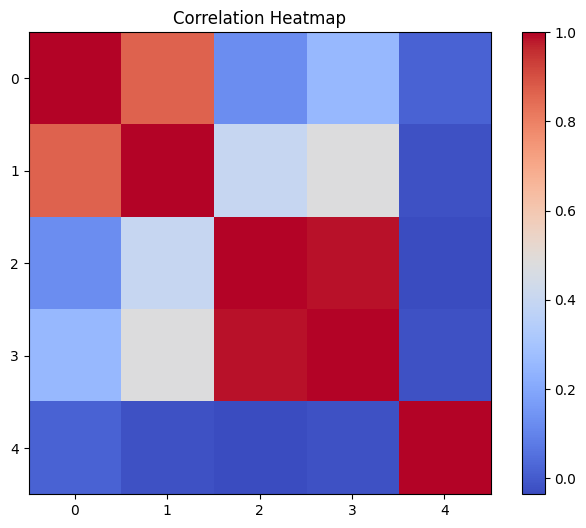

📊 Correlation matrix:
                           Gold Price (INR / 10gms)  Silver Price (INR / 1kg)  \
Gold Price (INR / 10gms)                     1.000                     0.864   
Silver Price (INR / 1kg)                     0.864                     1.000   
Price_Nifty                                  0.126                     0.400   
Price_Sensex                                 0.256                     0.478   
Impact                                       0.021                    -0.023   

                          Price_Nifty  Price_Sensex  Impact  
Gold Price (INR / 10gms)        0.126         0.256   0.021  
Silver Price (INR / 1kg)        0.400         0.478  -0.023  
Price_Nifty                     1.000         0.987  -0.036  
Price_Sensex                    0.987         1.000  -0.023  
Impact                         -0.036        -0.023   1.000  
✅ Correlation matrix saved.


In [13]:
# Convert 'Price_Nifty' and 'Price_Sensex' to numeric, handling commas
df['Price_Nifty'] = df['Price_Nifty'].astype(str).str.replace(',', '', regex=False)
df['Price_Sensex'] = df['Price_Sensex'].astype(str).str.replace(',', '', regex=False)
df['Price_Nifty'] = pd.to_numeric(df['Price_Nifty'])
df['Price_Sensex'] = pd.to_numeric(df['Price_Sensex'])

corr_matrix = df.drop(columns=["Date"]).corr()

plt.figure(figsize=(8,6))
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.title("Correlation Heatmap")
plt.show()

print("📊 Correlation matrix:\n", corr_matrix.round(3))

# Save correlation matrix
os.makedirs("/content/models", exist_ok=True)
corr_matrix.to_csv("/content/models/correlation_matrix.csv", index=True)
print("✅ Correlation matrix saved.")

In [14]:
# Select numeric features
features = ["Gold Price (INR / 10gms)", "Silver Price (INR / 1kg)",
            "Price_Nifty", "Price_Sensex", "Impact"]

# Input features (X) & targets (each asset)
X = df[features]

# Split target columns
targets = {
    "gold": df["Gold Price (INR / 10gms)"],
    "silver": df["Silver Price (INR / 1kg)"],
    "nifty": df["Price_Nifty"],
    "sensex": df["Price_Sensex"]
}

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

joblib.dump(scaler, "/content/models/scaler.pkl")
print("✅ Features scaled and scaler saved.")

✅ Features scaled and scaler saved.


In [15]:
models = {}

for name, y in targets.items():
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, shuffle=False
    )

    model = RandomForestRegressor(
        n_estimators=200, random_state=42, max_depth=12
    )
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    models[name] = model

    print(f"✅ {name.upper()} Model Trained | MAE: {mae:.2f} | R²: {r2:.3f}")

print("\nAll models trained successfully!")

✅ GOLD Model Trained | MAE: 1942.04 | R²: -0.991
✅ SILVER Model Trained | MAE: 11648.77 | R²: -2.185
✅ NIFTY Model Trained | MAE: 224.60 | R²: 0.803
✅ SENSEX Model Trained | MAE: 798.31 | R²: 0.792

All models trained successfully!


In [16]:
# Ensure model folder exists
os.makedirs("/content/models", exist_ok=True)

for name, model in models.items():
    path = f"/content/models/{name}_price_model.pkl"
    joblib.dump(model, path)
    print(f"💾 Saved {name} model → {path}")

print("✅ All models & scaler saved successfully!")

💾 Saved gold model → /content/models/gold_price_model.pkl
💾 Saved silver model → /content/models/silver_price_model.pkl
💾 Saved nifty model → /content/models/nifty_price_model.pkl
💾 Saved sensex model → /content/models/sensex_price_model.pkl
✅ All models & scaler saved successfully!


In [17]:
# Reload one model & predict next-day prices (example)
test_input = X.iloc[-1:].copy()
scaled_input = scaler.transform(test_input)

preds = {}
for name, model in models.items():
    preds[name] = model.predict(scaled_input)[0]

print("📅 Latest Date:", df["Date"].iloc[-1])
print("🔮 Predicted next-day prices:")
for k, v in preds.items():
    print(f"  {k.capitalize()}: {v:.2f}")

📅 Latest Date: 2020-12-30 00:00:00
🔮 Predicted next-day prices:
  Gold: 42846.04
  Silver: 44088.11
  Nifty: 12346.95
  Sensex: 41922.57


In [18]:
# Copy trained models to backend for FastAPI
BACKEND_MODEL_DIR = "/content/backend/models"
os.makedirs(BACKEND_MODEL_DIR, exist_ok=True)

!cp /content/models/*.pkl $BACKEND_MODEL_DIR
!cp /content/models/correlation_matrix.csv $BACKEND_MODEL_DIR

print("✅ Models exported to backend/models/ successfully!")

✅ Models exported to backend/models/ successfully!


In [20]:
def retrain_pipeline(data_path="/content/final_training_dataset.csv"):
    """
    Loads latest dataset, retrains models, and exports to backend/models/.
    """
    df = pd.read_csv(data_path)
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.fillna(method='ffill').fillna(method='bfill')

    # Convert 'Price_Nifty' and 'Price_Sensex' to numeric, handling commas
    df['Price_Nifty'] = df['Price_Nifty'].astype(str).str.replace(',', '', regex=False)
    df['Price_Sensex'] = df['Price_Sensex'].astype(str).str.replace(',', '', regex=False)
    df['Price_Nifty'] = pd.to_numeric(df['Price_Nifty'])
    df['Price_Sensex'] = pd.to_numeric(df['Price_Sensex'])

    X = df[features]
    X_scaled = scaler.fit_transform(X)

    for name, y in targets.items():
        model = RandomForestRegressor(n_estimators=200, random_state=42)
        model.fit(X_scaled, y)
        joblib.dump(model, f"/content/models/{name}_price_model.pkl")

    print("✅ Retraining complete and models updated.")

# Example usage:
retrain_pipeline()

/tmp/ipython-input-3719004462.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')


✅ Retraining complete and models updated.
